# Chapter 2 

In [103]:
# Listing 1-1

%matplotlib inline

import time
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
from scipy import stats
import seaborn

# from sklearn.grid_search import GridSearchCV # deprecated, moved to model_selection
from sklearn.model_selection import GridSearchCV
# from sklearn.cross_validation import train_test_split # deprecated, moved to model_selection
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import cross_val_score # deprecated, moved to model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RANSACRegressor, LinearRegression, TheilSenRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

from sklearn.svm import SVR
from sklearn.linear_model import Ridge,Lasso,ElasticNet,BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from IPython.display import Image

In [104]:
# Listing 1-2

data = pd.read_csv('datasets/Chapter 2/concrete_data.csv')

In [105]:
# Listing 1-3

print(len(data))
data.head()

1030


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [106]:
# Listing 1-4

data.columns = ['cement_component', 'furnace_slag', 'flay_ash', 'water_component', 'superplasticizer', \
	'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_strength']

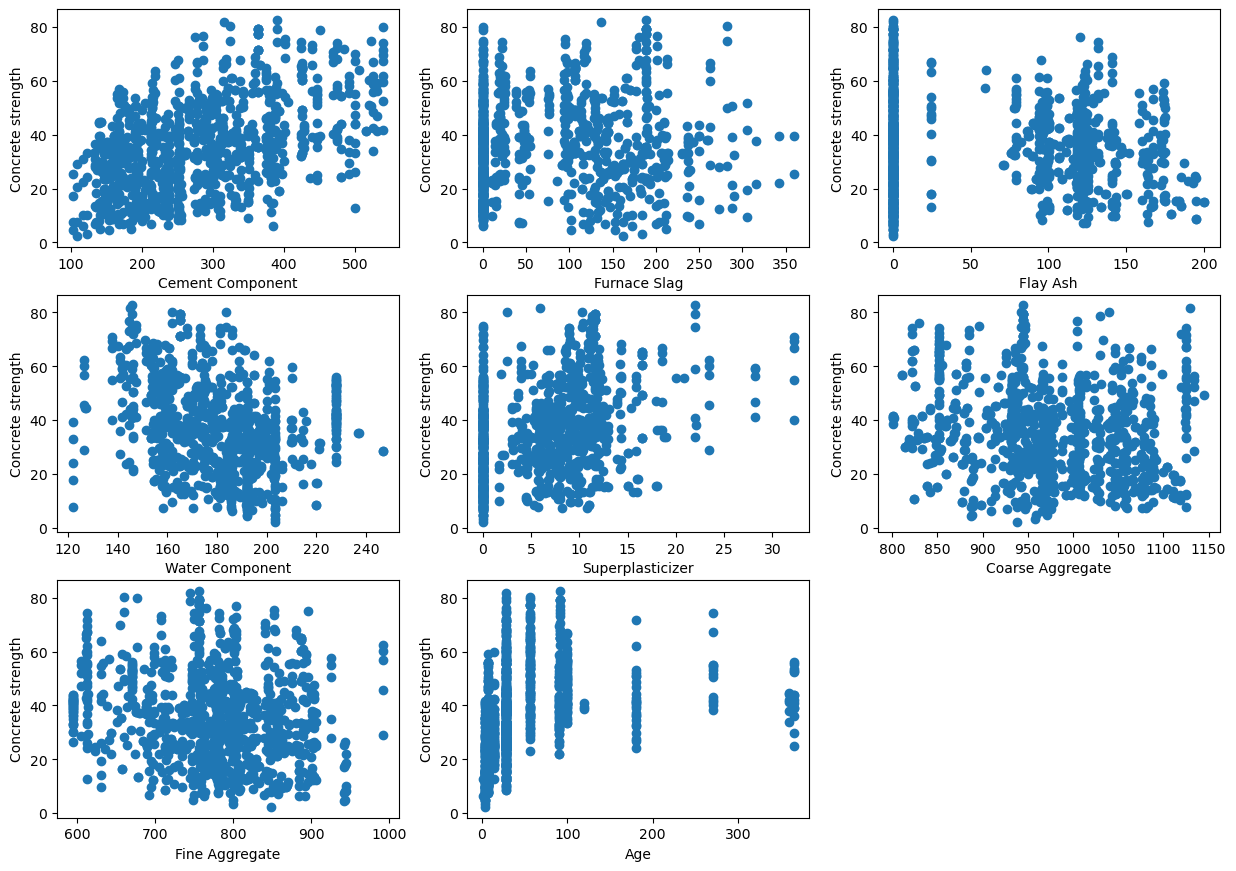

In [107]:
# Listing 1-5

plt.figure(figsize=(15,10.5))
plot_count = 1

for feature in list(data.columns)[:-1]:
        plt.subplot(3,3,plot_count)
        plt.scatter(data[feature], data['concrete_strength'])
        plt.xlabel(feature.replace('_',' ').title())
        plt.ylabel('Concrete strength')
        plot_count+=1
        
plt.show()

In [108]:
# Listing 1-6

pd.set_option('display.width', 100)
pd.set_option('display.precision', 3) # add 'display.' to precision attr
correlations = data.corr(method='pearson')
print(correlations)

                   cement_component  furnace_slag  flay_ash  water_component  superplasticizer  \
cement_component              1.000        -0.275    -0.397           -0.082             0.092   
furnace_slag                 -0.275         1.000    -0.324            0.107             0.043   
flay_ash                     -0.397        -0.324     1.000           -0.257             0.378   
water_component              -0.082         0.107    -0.257            1.000            -0.658   
superplasticizer              0.092         0.043     0.378           -0.658             1.000   
coarse_aggregate             -0.109        -0.284    -0.010           -0.182            -0.266   
fine_aggregate               -0.223        -0.282     0.079           -0.451             0.223   
age                           0.082        -0.044    -0.154            0.278            -0.193   
concrete_strength             0.498         0.135    -0.106           -0.290             0.366   

                   

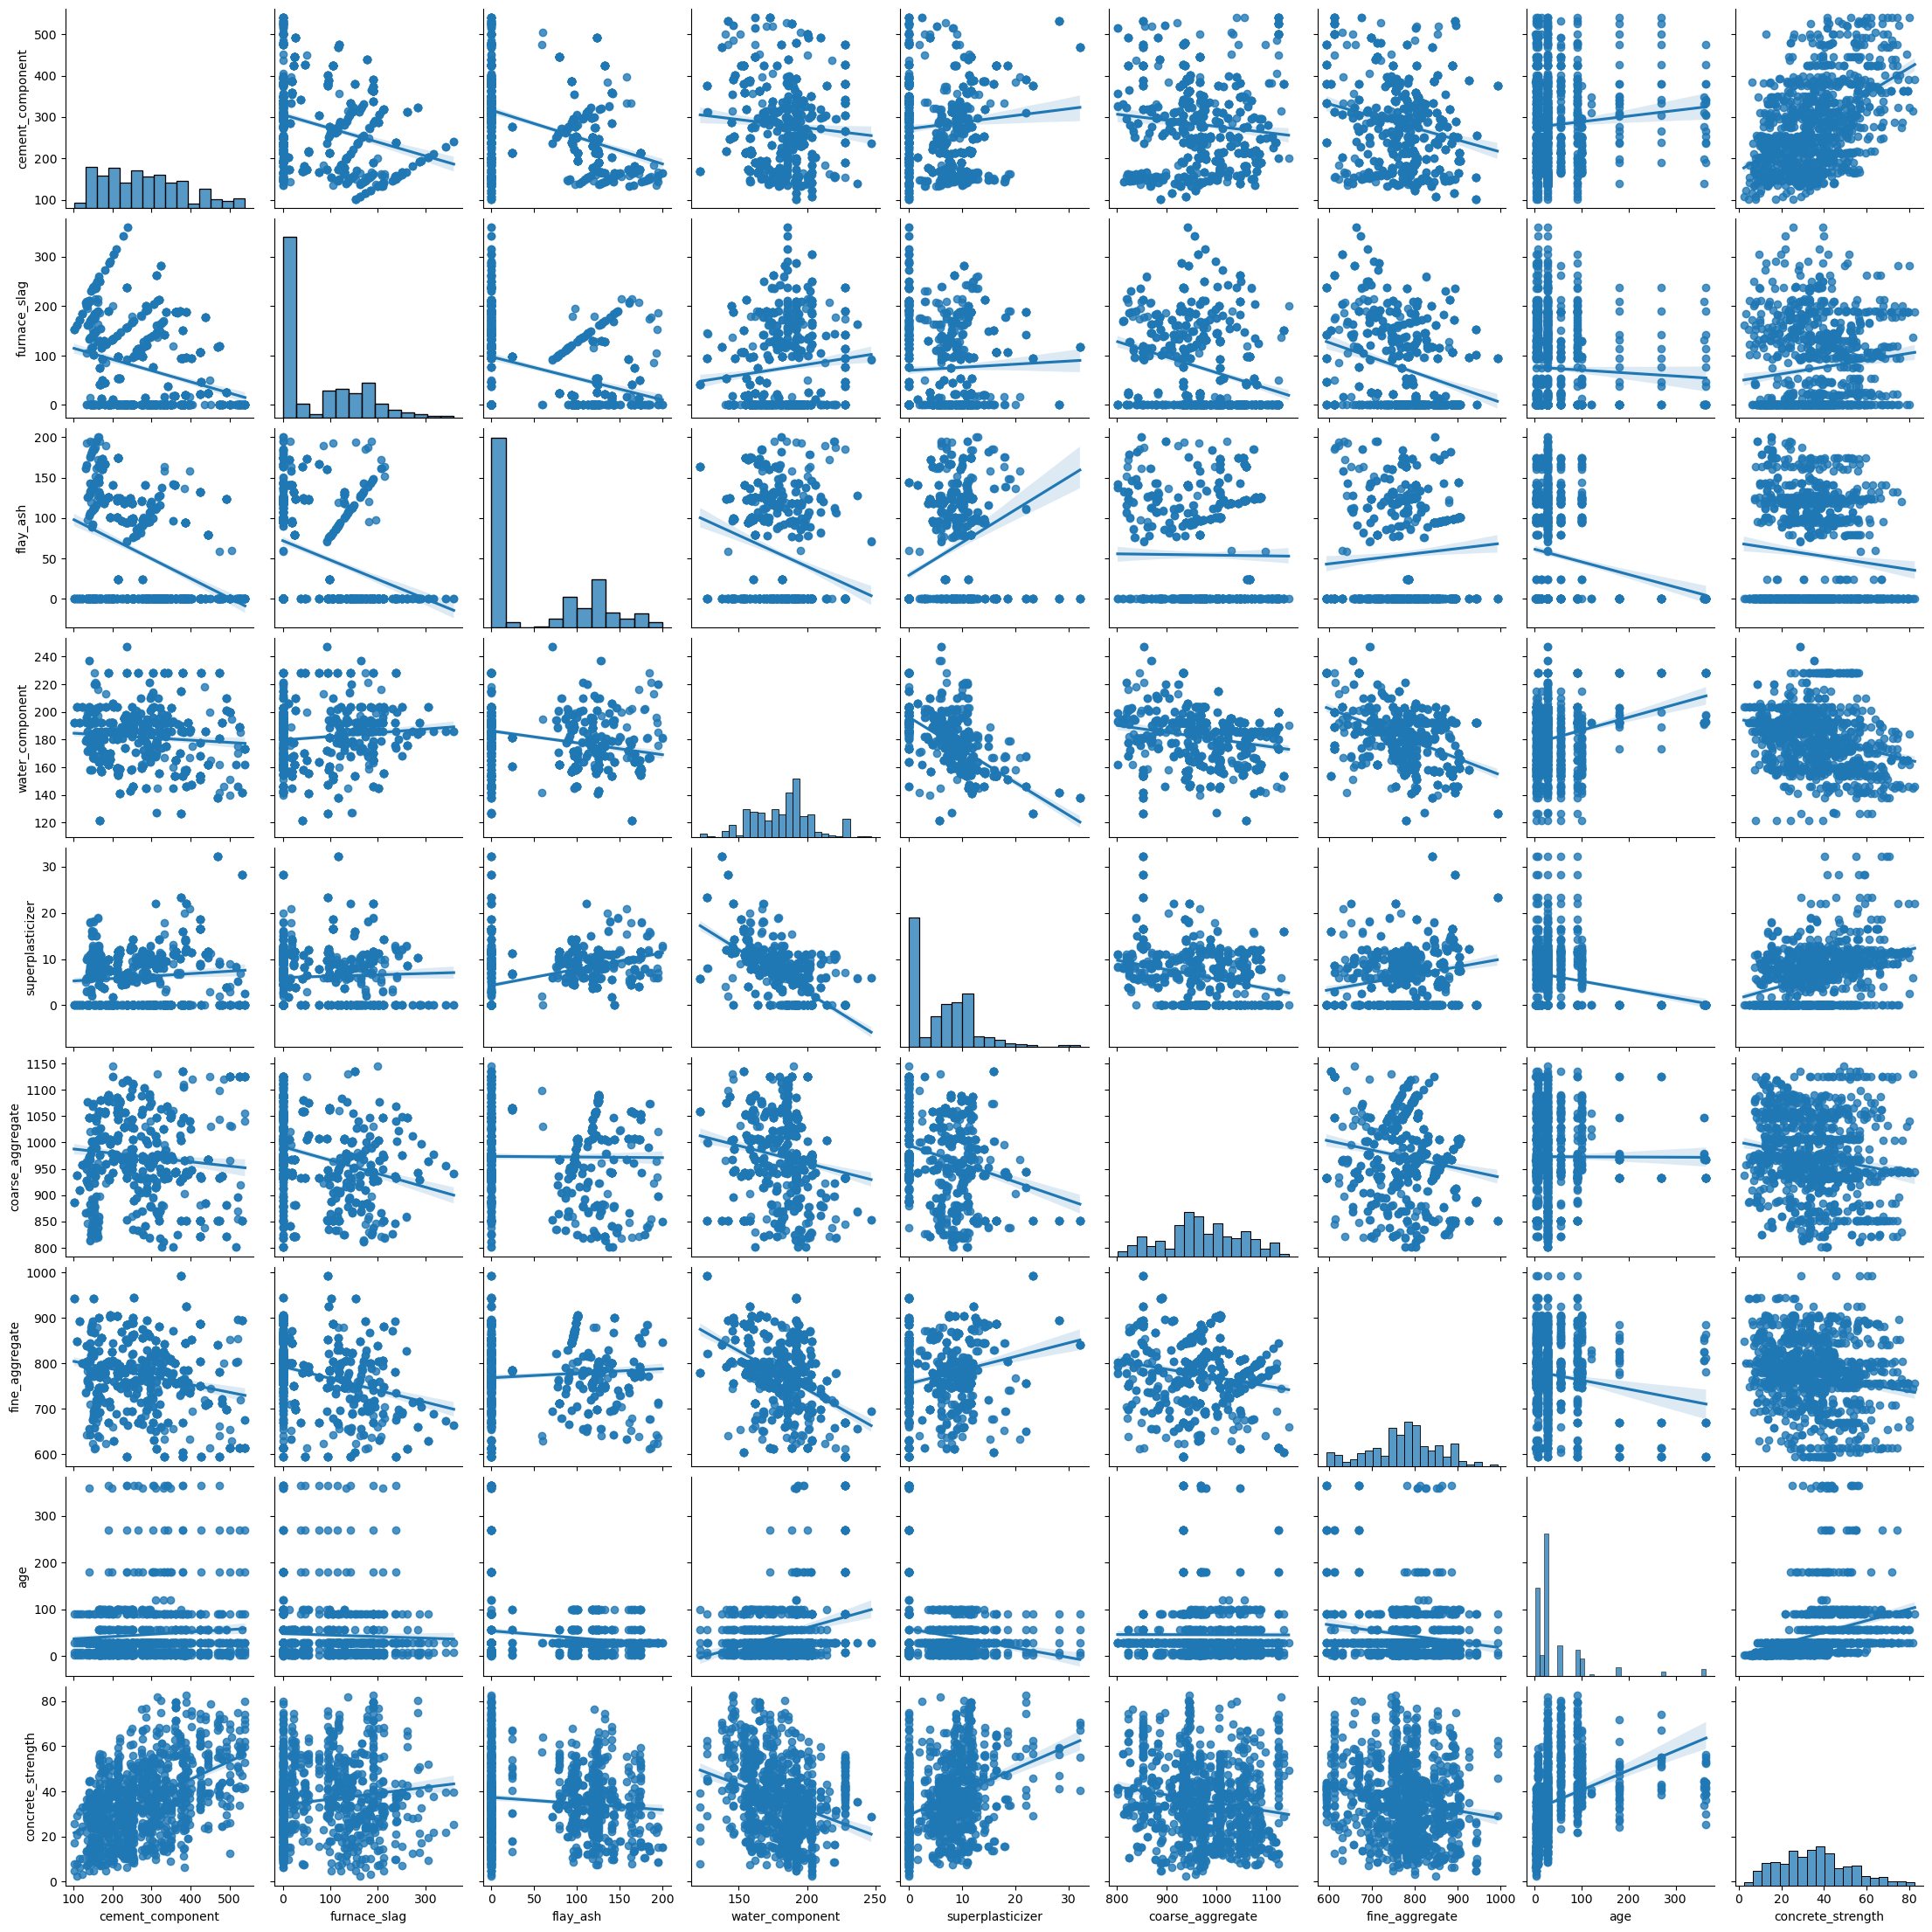

In [109]:
# Listing 1-7

data_ = data[(data.T != 0).any()]
seaborn.pairplot(data_, vars=data.columns, kind='reg')
plt.show()

In [110]:
# Listing 1-8

def split_train_test(data, feature, train_index=0.7):

    train, test = train_test_split(data, test_size = 1-train_index)

    if type(feature) == list:
        # pandas 0.23.0 (May 15, 2018)
        # .as_matrix()  is deprecated. Use DataFrame.values instead (GH18458).
        x_train = train[feature] # .as_matrix()
        y_train = train['concrete_strength'] # .as_matrix()

        x_test = test[feature] # .as_matrix()
        y_test = test['concrete_strength'] # .as_matrix()

    else:
        x_train = [[x] for x in list(train[feature])]
        y_train = [[x] for x in list(train['concrete_strength'])]

        x_test = [[x] for x in list(test[feature])]
        y_test = [[x] for x in list(test['concrete_strength'])]
        
    return x_train, y_train, x_test, y_test

cement_component 0.23496337573150505
flay_ash 0.09414865711275688
water_component 0.10324849237744849
superplasticizer 0.0509630262648717
coarse_aggregate 0.037403491414378265


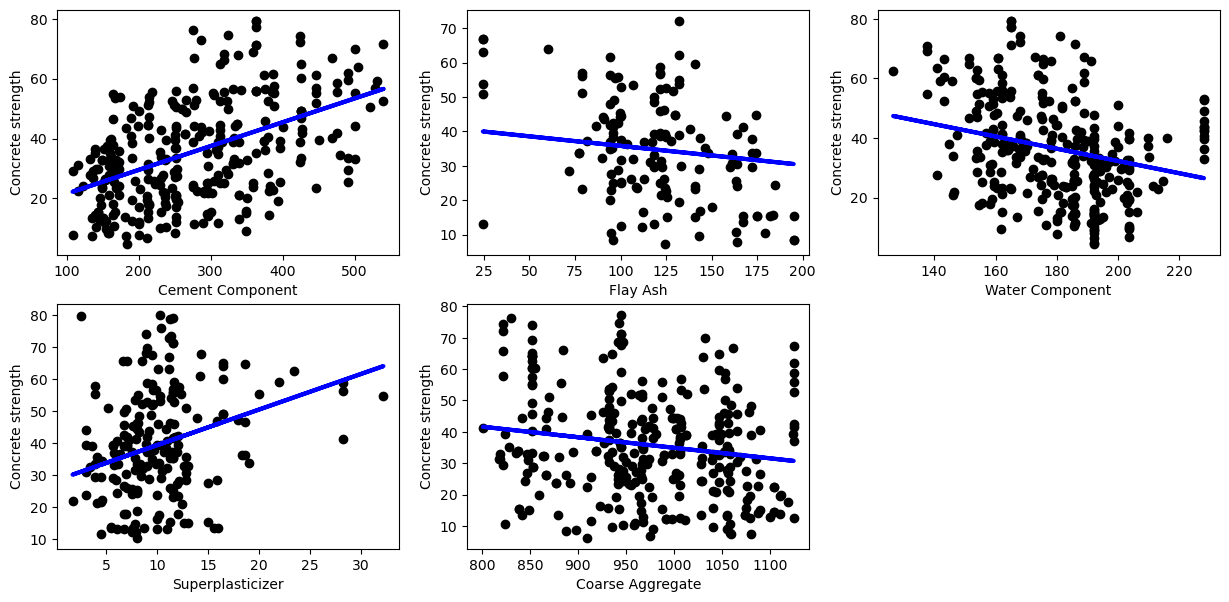

In [111]:
# Listing 1-9

plt.figure(figsize=(15,7))
plot_count = 1

for feature in ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']:
    data_tr = data[['concrete_strength', feature]]
    data_tr=data_tr[(data_tr.T != 0).all()]
    
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)

    # Create linear regression object
    regr = LinearRegression()

    # Train the model using the training sets
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    
    # Plot outputs
    plt.subplot(2,3,plot_count)
    
    plt.scatter(x_test, y_test,  color='black')
    plt.plot(x_test, y_pred, color='blue', linewidth=3)
    plt.xlabel(feature.replace('_',' ').title())
    plt.ylabel('Concrete strength')

    print(feature, r2_score(y_test, y_pred))
    
    plot_count+=1
        
plt.show()

Features:  ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score:  0.10095743579424121
Intercept:  73.62315642656839
Coefficients:  [ 0.0460206  -0.05290393 -0.16073136  0.0160748  -0.01222775]


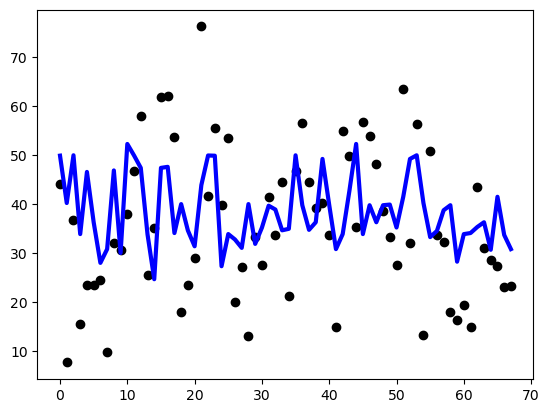

In [112]:
# Listing 1-10

features = ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']

data_tr = data
data_tr=data_tr[(data_tr.T != 0).all()]

x_train, y_train, x_test, y_test = split_train_test(data_tr, features)

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

plt.scatter(list(range(len(y_test))), y_test,  color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: ', str(features))
print('R2 score: ', r2_score(y_test, y_pred))
print('Intercept: ', regr.intercept_)
print('Coefficients: ', str(regr.coef_))

Features:  ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score:  0.10095659026263071


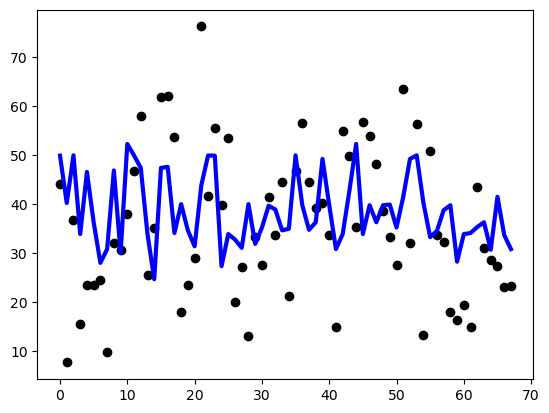

In [113]:
# Listing 1-11

alphas = np.arange(0.1,5,0.1)

model = Ridge()
cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))

y_pred = cv.fit(x_train, y_train).predict(x_test)

plt.scatter(list(range(len(y_test))), y_test,  color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: ', str(features))
print('R2 score: ', r2_score(y_test, y_pred))
# print('Intercept: %f'%regr.intercept_)
# print('Coefficients: %s'%str(regr.coef_))

Features:  ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score:  0.09956125235427771


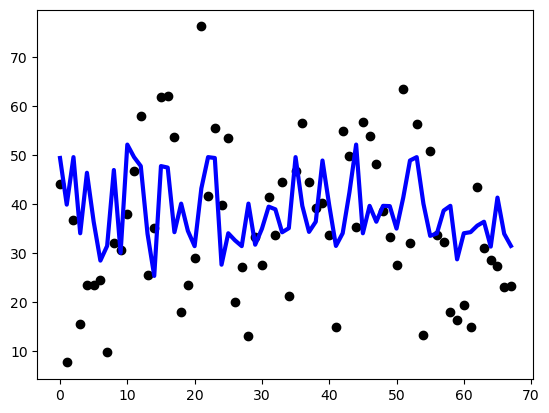

In [114]:
# Listing 1-12

model = Lasso()
cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))

y_pred = cv.fit(x_train, y_train).predict(x_test)

plt.scatter(list(range(len(y_test))), y_test,  color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: ', str(features))
print('R2 score: ', r2_score(y_test, y_pred))
# print('Intercept: ', model.intercept_)
# print('Coefficients: ', str(model.coef_))

Features:  ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score:  0.09975183590332914


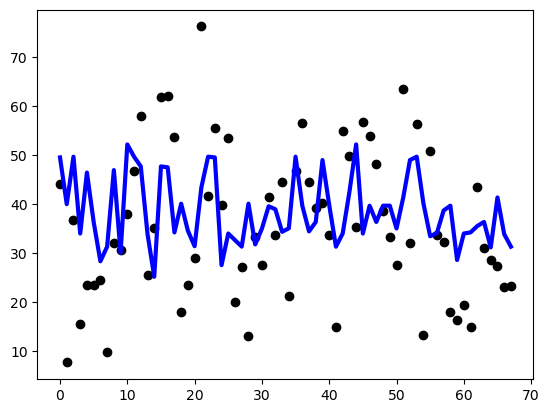

In [115]:
# Listing 1-13

model = ElasticNet()
cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))

y_pred = cv.fit(x_train, y_train).predict(x_test)

plt.scatter(list(range(len(y_test))), y_test,  color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: ', str(features))
print('R2 score: ', r2_score(y_test, y_pred))
# print('Intercept: ', regr.intercept_)
# print('Coefficients: ', str(regr.coef_))

cement_component 0.3722541992356516
flay_ash 0.05048810592238551
water_component 0.2794172211362608
superplasticizer 0.13695525069117265
coarse_aggregate 0.27355287648856685


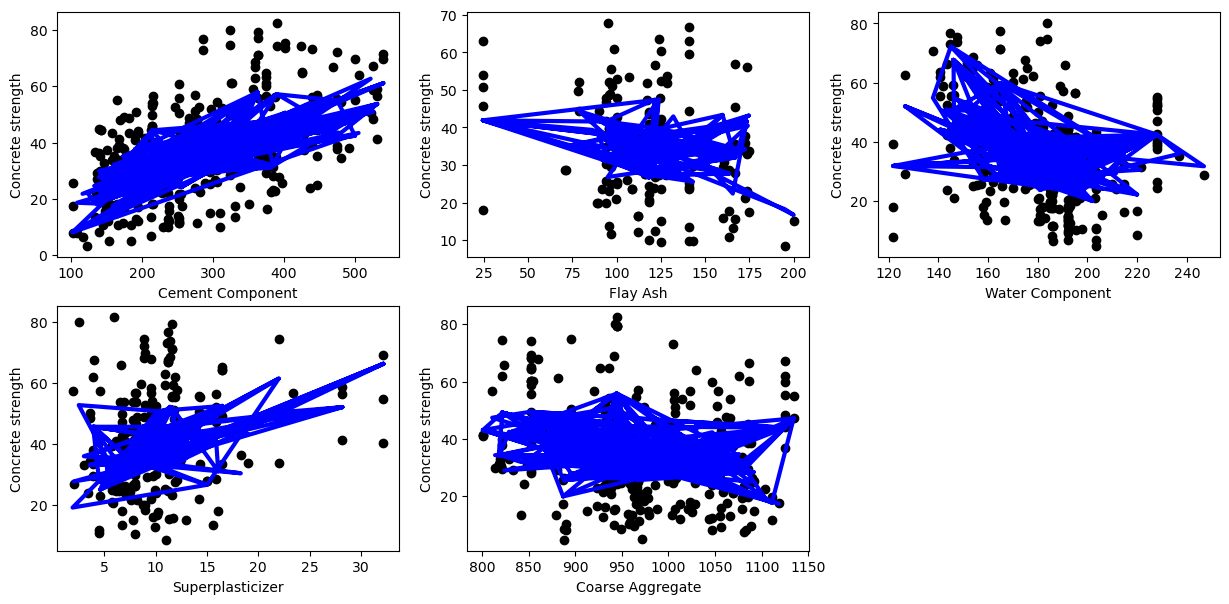

In [116]:
# Listing 1-14

plt.figure(figsize=(15,7))
plot_count = 1

for feature in ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']:
    data_tr = data[['concrete_strength', feature]]
    data_tr=data_tr[(data_tr.T != 0).all()]
    
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)

    # Create linear regression object
    regr = GradientBoostingRegressor()

    # Train the model using the training sets
    
    # regr.fit(x_train, y_train.values.ravel()) does not work, still 
    # DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
    regr.fit(x_train, np.ravel(y_train))
    y_pred = regr.predict(x_test)
    
    # Plot outputs
    plt.subplot(2,3,plot_count)
    
    plt.scatter(x_test, y_test,  color='black')
    plt.plot(x_test, y_pred, color='blue',
             linewidth=3)
    plt.xlabel(feature.replace('_',' ').title())
    plt.ylabel('Concrete strength')

    print(feature, r2_score(y_test, y_pred))
    
    plot_count+=1
        
plt.show()

Features:  ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score:  0.27355287648856685


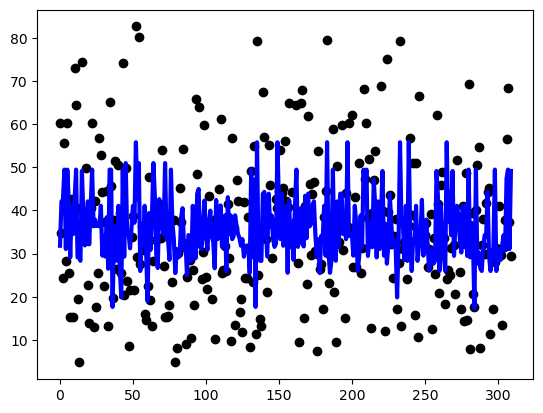

In [117]:
# Listing 1-15

model = GradientBoostingRegressor()

model.fit(x_train, np.ravel(y_train))
y_pred = model.predict(x_test)

plt.scatter(list(range(len(y_test))), y_test,  color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: ', str(features))
print('R2 score: ', r2_score(y_test, y_pred))
# print('Intercept: %f'%regr.intercept_) # AttributeError: 'GradientBoostingRegressor' object has no attribute 'intercept_'
# print('Coefficients: %s'%str(regr.coef_))

cement_component 0.20886180706328894
flay_ash 0.038560544621224935
water_component 0.08109768374087223
superplasticizer 0.13897233823052357
coarse_aggregate -0.03836712247318008


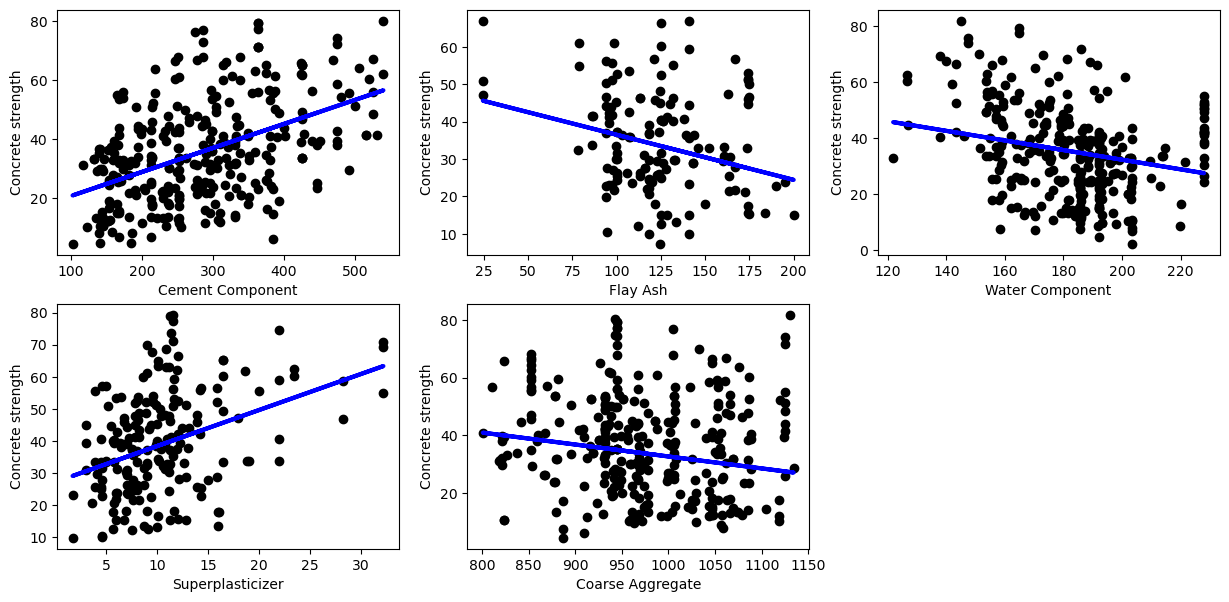

In [118]:
# Listing 1-16

plt.figure(figsize=(15,7))
plot_count = 1

for feature in ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']:
    data_tr = data[['concrete_strength', feature]]
    data_tr=data_tr[(data_tr.T != 0).all()]
    
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)

    # Create linear regression object
    regr = SVR(kernel='linear')

    # Train the model using the training sets
    regr.fit(x_train, np.ravel(y_train))
    y_pred = regr.predict(x_test)
    
    # Plot outputs
    plt.subplot(2,3,plot_count)
    
    plt.scatter(x_test, y_test,  color='black')
    plt.plot(x_test, y_pred, color='blue', linewidth=3)
    plt.xlabel(feature.replace('_',' ').title())
    plt.ylabel('Concrete strength')

    print(feature, r2_score(y_test, y_pred))
    
    plot_count+=1
        
plt.show()

Features:  ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score:  -0.03836712247318008


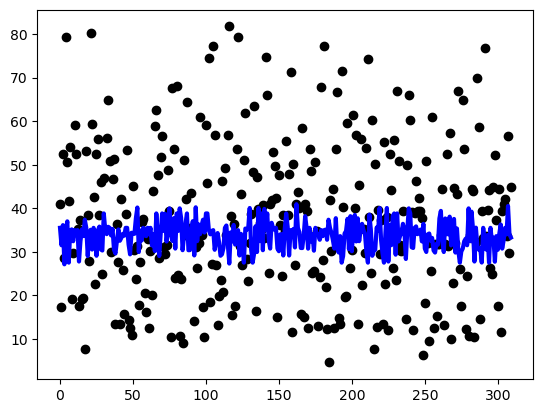

In [119]:
# Listing 1-17

model = SVR(kernel='linear')

y_pred = model.fit(x_train, np.ravel(y_train)).predict(x_test)

plt.scatter(list(range(len(y_test))), y_test,  color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: ', str(features))
print('R2 score: ', r2_score(y_test, y_pred))

In [120]:
# Listing 1-18

feature = 'cement_component'
cc_new_data = np.array([213.5])

data_tr = data[['concrete_strength', feature]]
data_tr=data_tr[(data_tr.T != 0).all()]

x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)

regr = GradientBoostingRegressor()

# Train the model using the training sets

regr.fit(x_train, np.ravel(y_train))
cs_pred = regr.predict(cc_new_data.reshape(-1, 1))
print('Predicted value of concrete strength: ', cs_pred)

Predicted value of concrete strength:  [39.34439519]


In [121]:
# Listing 1-19

feature = 'water_component'
wc_new_data = np.array([200])

data_tr = data[['concrete_strength', feature]]
data_tr=data_tr[(data_tr.T != 0).all()]

x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)

regr = GradientBoostingRegressor()

# Train the model using the training sets
regr.fit(x_train, np.ravel(y_train))
cs_pred = regr.predict(wc_new_data.reshape(-1, 1))
print('Predicted value of concrete strength: ', cs_pred)

Predicted value of concrete strength:  [35.98807614]


In [122]:
# Listing 1-20

feature = 'coarse_aggregate'
ca_new_data = np.array([1000])

data_tr = data[['concrete_strength', feature]]
data_tr=data_tr[(data_tr.T != 0).all()]

x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)

regr = GradientBoostingRegressor()

# Train the model using the training sets
regr.fit(x_train, np.ravel(y_train))
cs_pred = regr.predict(ca_new_data.reshape(-1, 1))
print('Predicted value of concrete strength: ', cs_pred)

Predicted value of concrete strength:  [31.6988169]
